In [2]:
from vit_pytorch import ViT
import torch

im gna pass in 3 observations and do a forward pass thru the model to test out my hook. im not expecting anything sensible yet, just want to make sure the shapes work out and that i can actually pull the weights from the last MHA block for regularization. patch_size = 14x14 so 36 patches

In [3]:
data = torch.load('/scr/nityakas/gaze_vit_v2/dataset/Breakout/num_episodes_20_fs4_human.pt', weights_only=False)

obs = data['observations']
actions = data['actions']

In [4]:
env = 'Breakout'
seed = 42
datapath = '../dataset/'
conf_type='normal'
train_type = 'normal'
conf_randomness = 0.0
stack = 1
num_episodes = 2
use_gaze = True
gaze_method = 'Reg'
data_source = 'Our'
gaze_mask_sigma=gaze_mask_sigma = 15.0
gaze_mask_coef=gaze_mask_coeff = 0.7

patch_size = (14, 14)

In [5]:
import sys
sys.path.append('..')

from GABRIL_utils.utils import load_dataset

observations, actions, gaze_masks, gaze_coordinates = load_dataset(
        env=env,
        seed=seed,
        datapath=datapath,
        conf_type=conf_type,
        conf_randomness=conf_randomness,
        stack=stack,
        num_episodes=num_episodes,
        use_gaze=use_gaze,
        data_source=data_source,
        gaze_mask_sigma=gaze_mask_sigma,
        gaze_mask_coef=gaze_mask_coeff                
    )

100%|██████████| 2/2 [00:00<00:00, 185.78it/s]


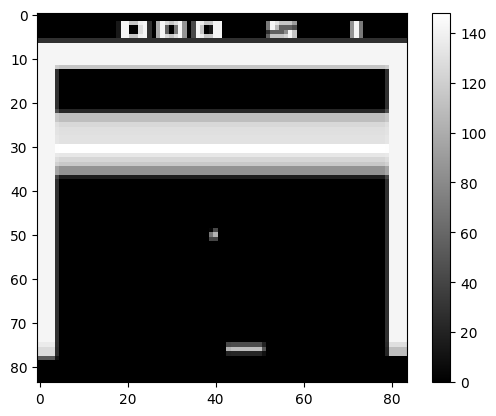

In [6]:
idx = 12

import matplotlib.pyplot as plt

plt.imshow(observations[idx].squeeze().numpy(), cmap='gray')
plt.colorbar()
plt.savefig(f'observation{idx}.jpeg') # GABRIL paper mentions the observations are grayscale
plt.show() 

this shows the values not between 0 and 1 so i still need to normalize. also i got an error screaming that the values werent floats so will need to change the datatype as well

In [7]:
# create a small batch to test with
batch_size = 3
obs_batch = torch.stack([observations[i] for i in range (3)])
obs_batch = obs_batch.float() / 255.0 # change datatype and normalize
actions_batch = torch.concat([actions[0:3]])


In [8]:
print(obs_batch.shape)
print(actions_batch.shape)

torch.Size([3, 1, 84, 84])
torch.Size([3])


the model should output (3, 4): 
- 3 actions, one for each timestep passed in
- 4 possible actions in the action space, one probability for each

Pytorch's CrossEntropyLoss will compare that with the integer scalar labels, so actually it makes perfect sense that actions shape is (3, ). torch.Size([3]) indicates 1D bc there's only 1 number. if it were 2D it'd say torch.Size([3, 1])

In [9]:
from omegaconf import OmegaConf, DictConfig
import os

cfg = OmegaConf.load('/scr/nityakas/gaze_vit_v2/config/vit_s_14.yaml')
vit = ViT(**cfg) # type: ignore

added `# type: ignore` bc Pylance is being a diva for no reason

In [10]:
out_actions = vit(obs_batch)

In [11]:
print(out_actions.shape)
print(out_actions)

torch.Size([3, 4])
tensor([[-0.2924,  0.0526, -0.3346,  0.3734],
        [-0.2924,  0.0526, -0.3346,  0.3734],
        [-0.2924,  0.0526, -0.3346,  0.3734]], grad_fn=<AddmmBackward0>)


the output is the correct shape woo! the fact that the 4 numbers dont add to 1 is ok because the model outputs logits, not softmaxed probability values. CrossEntropyLoss actually expects this and does its own softmax internally :)

now i gotta write my own hook to extract the attention weights of the last block's MHA layer. well actually lucidrains is simple enough that the hook approach leans overengineering but ive alr started so :)

Some fun facts abt hooks:
- The hook function signature is mandatory - it must accept exactly 3 parameters: (layer, input, output). u can call them whatever u want but they're positional args so u cant switch their order

`x = torch.cat((cls_tokens, x), dim = 1)` indicates CLS token comes first (index 0)

lucidrains is so nice, in Attention's forward() they're doing 
```
dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
attn = self.attend(dots)
```
so i can get out the inputs to the attend layer

In [18]:
# prelim hook to test the waters, see what we're dealing with
class AttentionExtractor:
    def __init__(self):
        self.attention_weights = None
    
    def hook_fn(self, layer, input, output):
        print("Hook fired!")
        print(input)
        self.attention_weights = input


print(vit) # wanna see what layers i can attach the hook to

extractor = AttentionExtractor()  
# Register it on a specific layer; Pytorch then calls hook_fn for u automatically when the forward pass happens at that layer(s)
handle = vit.transformer.layers[-1][0].attend.register_forward_hook(extractor.hook_fn) # type: ignore

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=14, p2=14)
    (1): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=196, out_features=384, bias=True)
    (3): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=384, out_features=1152, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=384, out_features=384, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            

note that this order that pytorch chooses to display doesnt necessarily reflect the order in which the layers area called. for example to_qkv is called before attend

- -1 indexes into the last block in the ModuleList
- 0 indexes into Attention within the block (bc each block contains Attention and FeedForward)

In [ ]:
# now we test out the hook by running a forward pass
out_actions = vit(obs_batch)
print(extractor.attention_weights[0].shape) # type: ignore

Hook fired!
(tensor([[[[-0.1903, -0.1768,  0.2506,  ...,  0.2457,  0.5149, -0.1943],
          [-0.2042, -0.3205,  0.4295,  ..., -0.3776, -0.3854,  0.1243],
          [-0.2130,  0.0340,  0.1925,  ..., -0.3887,  0.3996,  0.1533],
          ...,
          [-0.2993, -0.0081,  0.2204,  ...,  0.0973,  0.4486,  0.4955],
          [-0.4400, -0.0817,  0.1157,  ...,  0.6147, -0.1983,  0.6525],
          [-0.2710, -0.1600, -0.7064,  ..., -0.3886,  0.1968, -0.1570]],

         [[-0.3189,  0.0362,  0.1981,  ..., -0.0065,  0.8418, -0.3483],
          [ 0.1853, -0.1494,  0.2821,  ...,  0.0949,  0.0068, -0.2542],
          [-0.2259,  0.0761,  0.0262,  ...,  0.2416,  0.2243, -0.1225],
          ...,
          [ 0.2714,  0.0534,  0.2780,  ...,  0.0108,  0.2991, -0.3155],
          [ 0.5064, -0.0923,  0.0854,  ...,  0.6578, -0.3823, -0.2988],
          [ 0.8741, -0.2723, -0.1249,  ..., -0.4333,  0.2977, -0.5179]],

         [[ 0.1996,  0.5878,  0.6250,  ...,  0.3576, -0.2803,  0.2206],
          [ 0.619

- 3 = batch
- 6 = num heads
- 37 = num patches + cls token
37x37 bc each patch is paying attention to itself and the other 36 patches (37 numbers for one patch) then u do that for all 37 patches. 

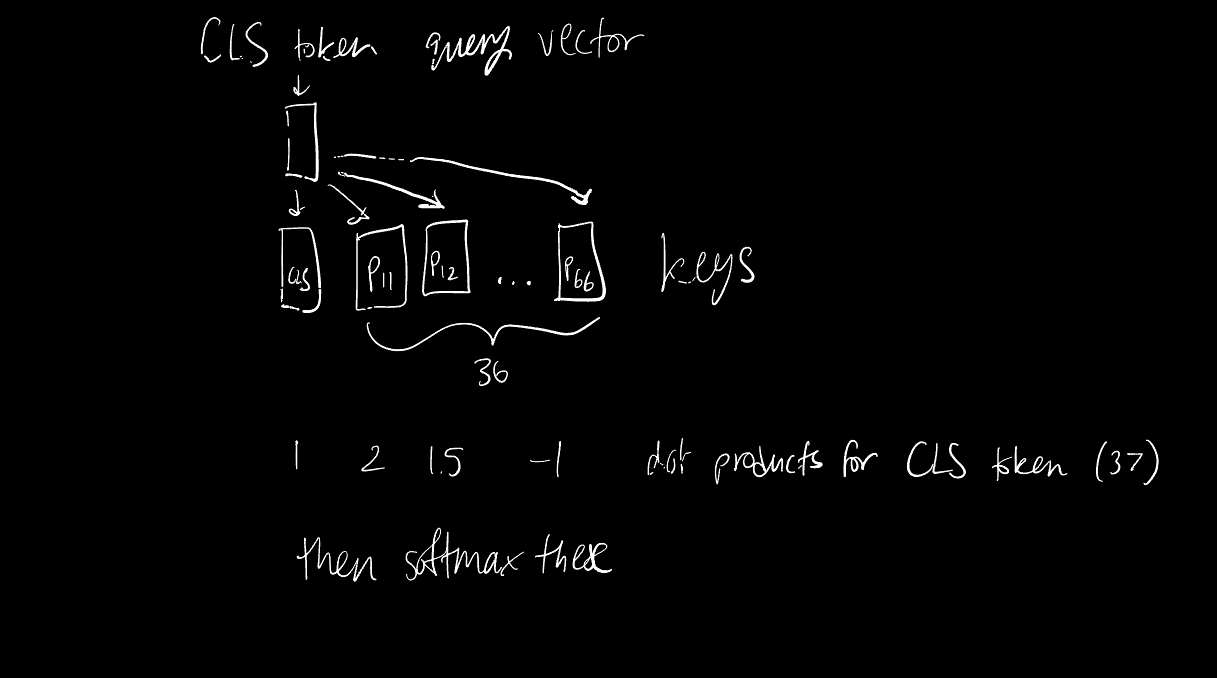

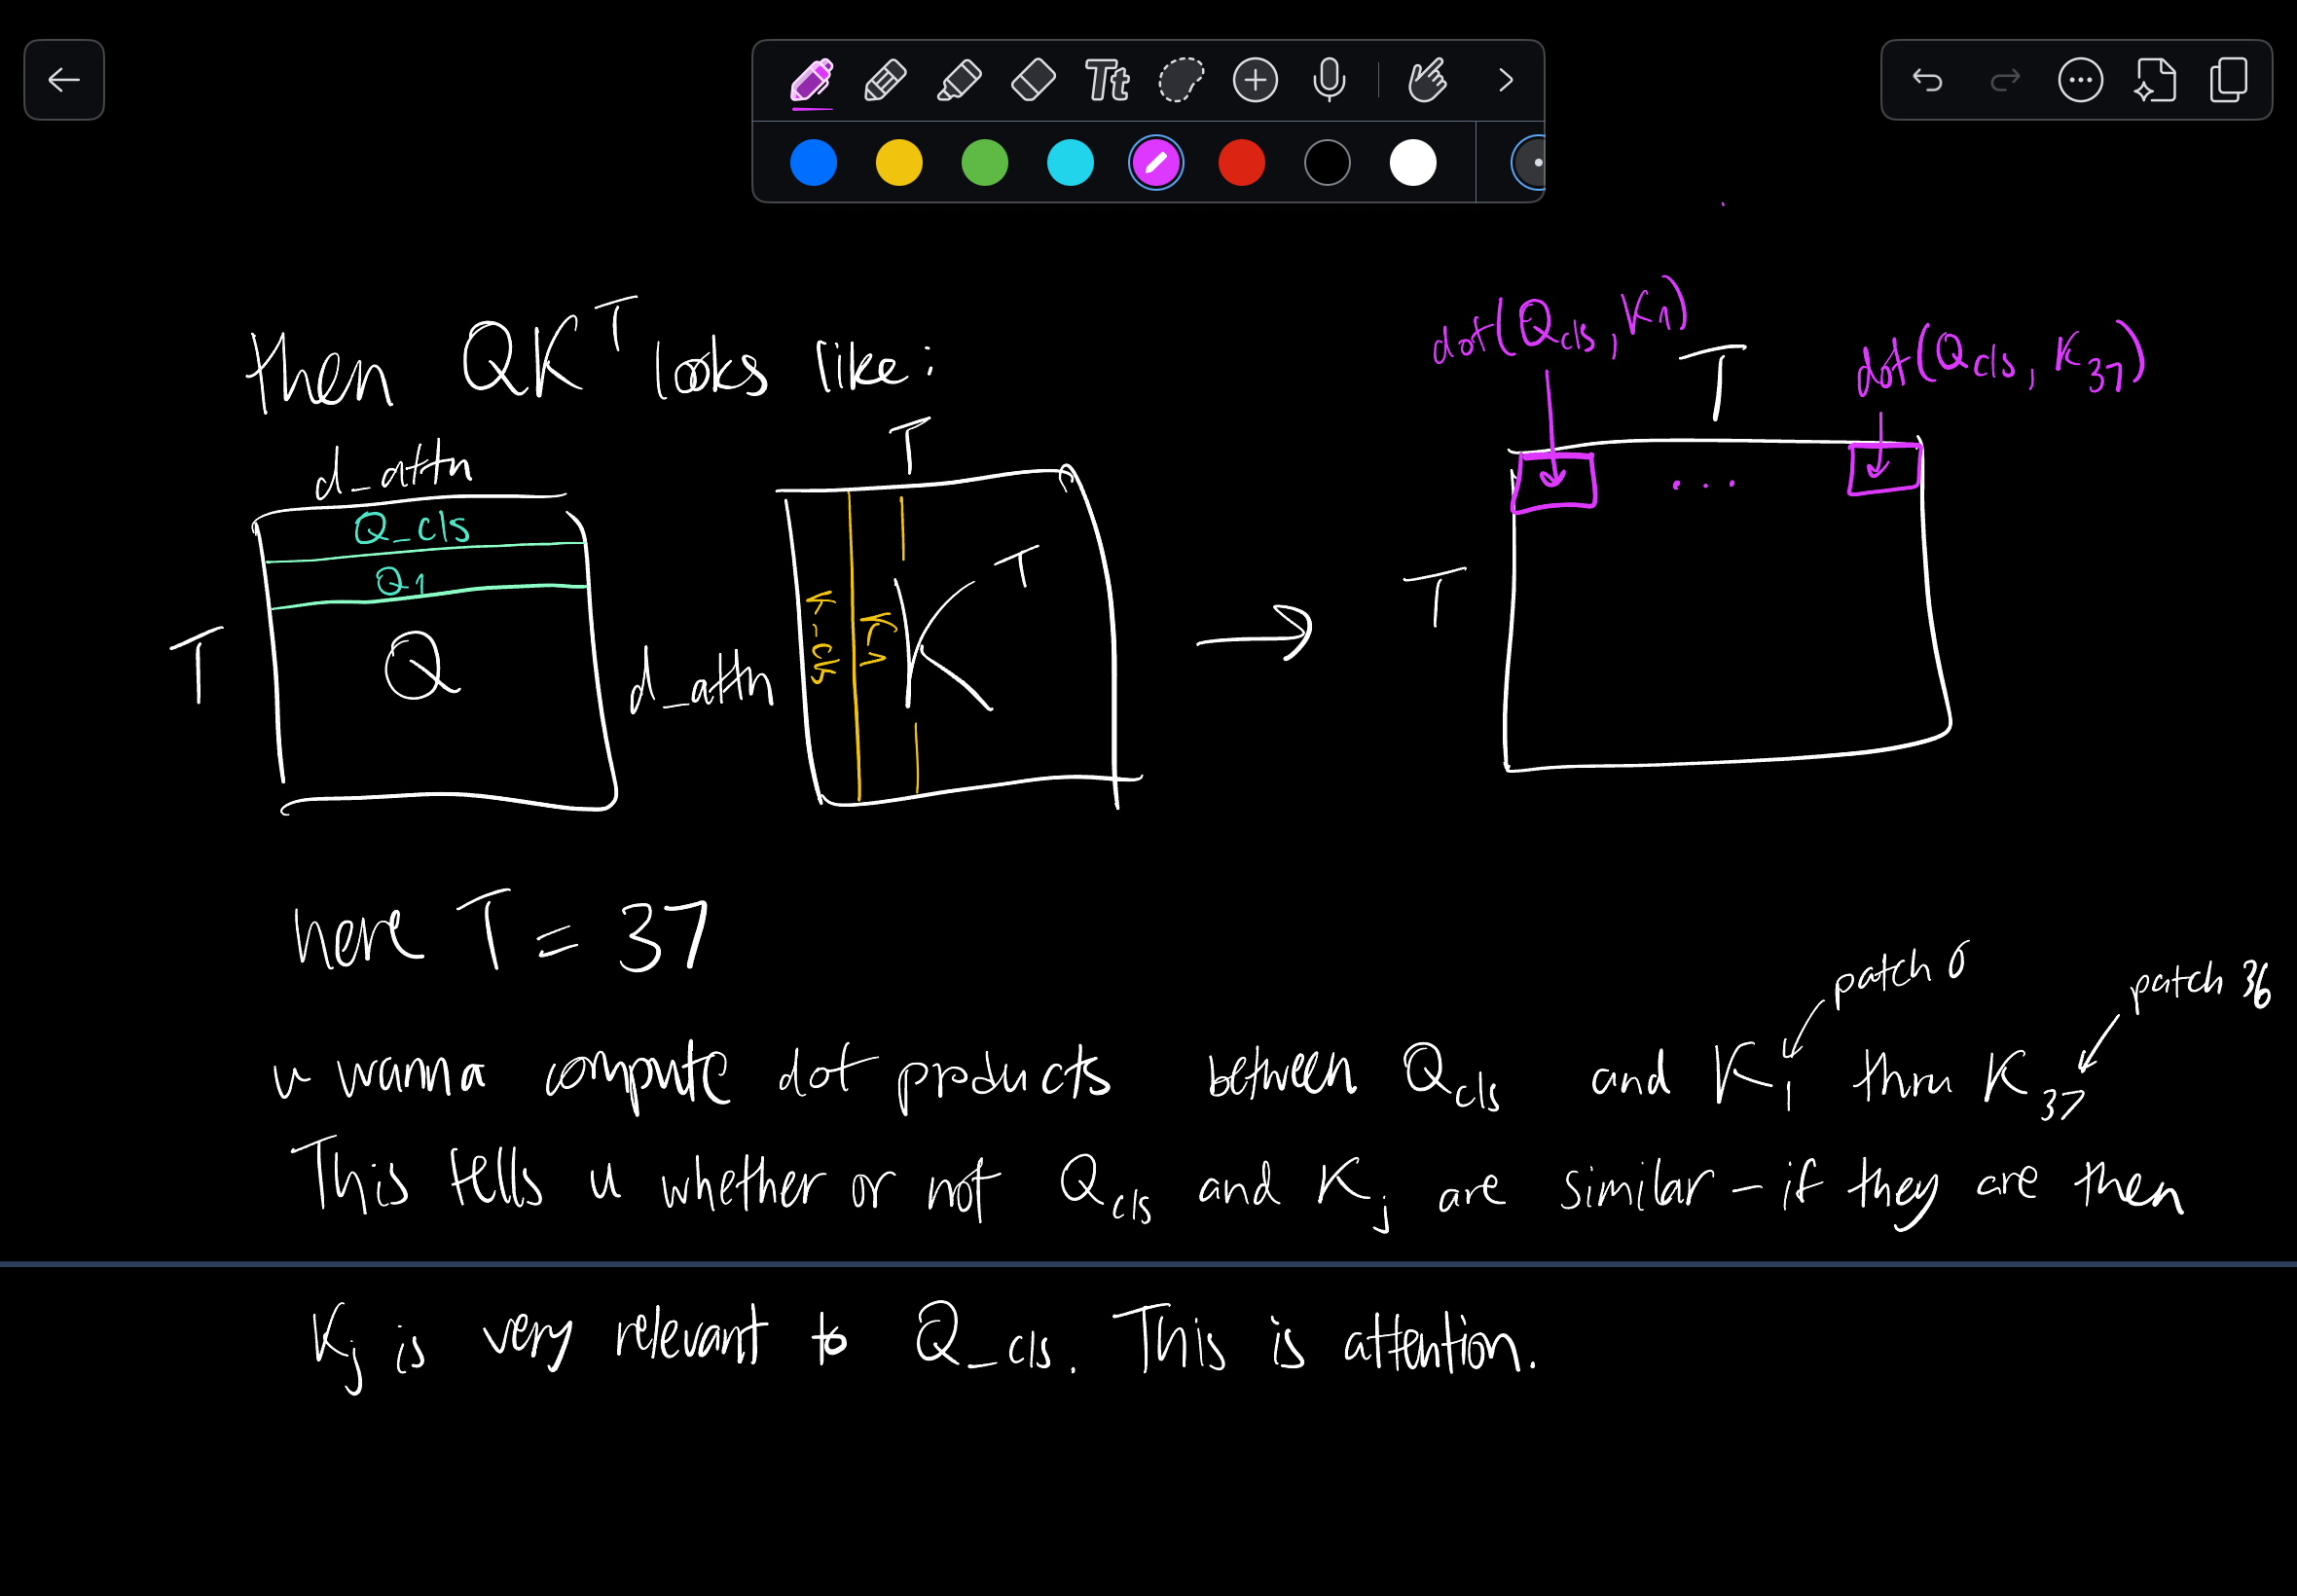

In [ ]:
vit.transformer.layers[-1][0].attend._forward_hooks.clear() # clear out all stale hooks

In [38]:
# actual hook
class AttentionExtractor:
    def __init__(self):
        self.cls_qkt_logits = None 
    
    def hook_fn(self, layer, input, output):
        # im leaving out the processing logic and keeping the hook dumb- softmaxing is part of the regularization computation, the hook is only supposed to return what it gets from the model
        dots = input[0] # input comes in as a tuple wrapping the output tensor so u need to index into it
        self.cls_qkt_logits = dots[:, :, 0, 1:] # leave 1st and 2 dims alone, grab only 1st row of third (cls dot prods), exclude 1st element of columns (bc that's cls self attn)
        print(self.cls_qkt_logits.shape)

extractor = AttentionExtractor()  
# Register it on a specific layer; Pytorch then calls hook_fn for u automatically when the forward pass happens at that layer(s)
handle = vit.transformer.layers[-1][0].attend.register_forward_hook(extractor.hook_fn) # type: ignore


In [39]:
# now we test out the hook by running a forward pass
out_actions = vit(obs_batch)

tensor([[[[-0.1903, -0.1768,  0.2506,  ...,  0.2457,  0.5149, -0.1943],
          [-0.2042, -0.3205,  0.4295,  ..., -0.3776, -0.3854,  0.1243],
          [-0.2130,  0.0340,  0.1925,  ..., -0.3887,  0.3996,  0.1533],
          ...,
          [-0.2993, -0.0081,  0.2204,  ...,  0.0973,  0.4486,  0.4955],
          [-0.4400, -0.0817,  0.1157,  ...,  0.6147, -0.1983,  0.6525],
          [-0.2710, -0.1600, -0.7064,  ..., -0.3886,  0.1968, -0.1570]],

         [[-0.3189,  0.0362,  0.1981,  ..., -0.0065,  0.8418, -0.3483],
          [ 0.1853, -0.1494,  0.2821,  ...,  0.0949,  0.0068, -0.2542],
          [-0.2259,  0.0761,  0.0262,  ...,  0.2416,  0.2243, -0.1225],
          ...,
          [ 0.2714,  0.0534,  0.2780,  ...,  0.0108,  0.2991, -0.3155],
          [ 0.5064, -0.0923,  0.0854,  ...,  0.6578, -0.3823, -0.2988],
          [ 0.8741, -0.2723, -0.1249,  ..., -0.4333,  0.2977, -0.5179]],

         [[ 0.1996,  0.5878,  0.6250,  ...,  0.3576, -0.2803,  0.2206],
          [ 0.6196, -0.1609,  

wahooo shapes look correct! 
- 3 = batch size
- 6 = num heads
- 36 = num patches